# Cell Segmentation Pipeline

Complete pipeline for cell segmentation and quality control:
1. Load image and manual mask
2. Segment cells using watershed algorithm
3. Export cell ROIs for ImageJ
4. Export raw crops for quality filtering
5. Filter bad cells (separate notebook)
6. Apply padding to good cells

In [1]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from skimage import measure, io
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage as ndi
from matplotlib.patches import Rectangle

In [2]:
# Configuration - Update these paths for your data
base_dir = '/Users/taeeonkong/Desktop/Project/Summer2025/20250729_CLLSaSa/1to10/sample1/2'
raw_filename = 'CLLSaSa_07292025_1to10_40min_1_02_raw.jpg'
mask_filename = 'CLLSaSa_07292025_1to10_40min_1_02_mask.jpg'

# Segmentation parameters (from taeeon_version4)
MIN_DISTANCE = 12  # Peak detection distance
MIN_SIZE = 500     # Minimum cell size in pixels
MAX_SIZE = 9000    # Maximum cell size in pixels

In [3]:
# Core segmentation functions (from taeeon_version4)

def load_image(image_path):
    """Load an image as grayscale numpy array"""
    return np.array(Image.open(image_path).convert('L'))

def split_touching_cells(mask, min_distance=12):
    """Use distance transform + watershed to split touching cells"""
    distance = ndi.distance_transform_edt(mask)
    
    # Get coordinates of local maxima
    coords = peak_local_max(distance, min_distance=min_distance, labels=mask)
    
    # Create marker image from coordinates
    local_max = np.zeros_like(distance, dtype=bool)
    local_max[tuple(coords.T)] = True
    markers = ndi.label(local_max)[0]
    
    # Apply watershed
    labels = watershed(-distance, markers, mask=mask)
    return labels

def segment_cells_from_mask(image, mask, min_size=500, max_size=9000):
    """Segment individual cells from a mask using watershed"""
    binary_mask = mask > 0
    
    # Split overlapping cells using watershed
    labeled_mask = split_touching_cells(binary_mask, min_distance=MIN_DISTANCE)
    
    regions = measure.regionprops(labeled_mask, intensity_image=image)
    
    # Filter by size
    valid_regions = []
    valid_bboxes = []
    
    for region in regions:
        if min_size <= region.area <= max_size:
            valid_regions.append(region)
            
            # Convert bbox to (x, y, w, h) format
            minr, minc, maxr, maxc = region.bbox
            x, y = minc, minr
            w, h = maxc - minc, maxr - minr
            valid_bboxes.append((x, y, w, h))
    
    return valid_regions, valid_bboxes, labeled_mask

Loading files:
Raw: /Users/taeeonkong/Desktop/Project/Summer2025/20250729_CLLSaSa/1to10/sample1/2/CLLSaSa_07292025_1to10_40min_1_02_raw.jpg
Mask: /Users/taeeonkong/Desktop/Project/Summer2025/20250729_CLLSaSa/1to10/sample1/2/CLLSaSa_07292025_1to10_40min_1_02_mask.jpg
✅ Loaded image: (1002, 1004)
✅ Loaded mask: (1002, 1004)


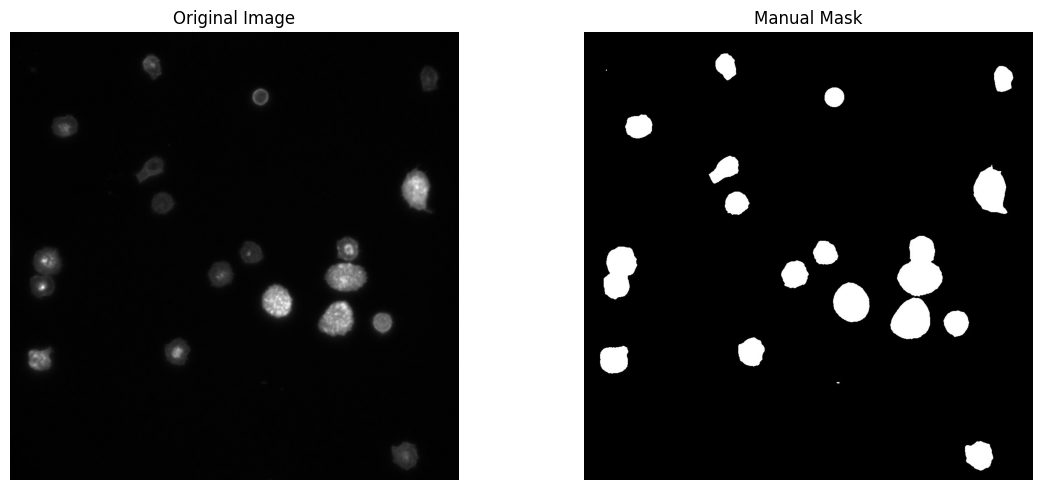

In [4]:
# Load image and mask
raw_path = os.path.join(base_dir, raw_filename)
mask_path = os.path.join(base_dir, mask_filename)

print(f"Loading files:")
print(f"Raw: {raw_path}")
print(f"Mask: {mask_path}")

if os.path.exists(raw_path) and os.path.exists(mask_path):
    image = load_image(raw_path)
    mask = load_image(mask_path)
    
    print(f"✅ Loaded image: {image.shape}")
    print(f"✅ Loaded mask: {mask.shape}")
    
    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.imshow(image, cmap='gray')
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    ax2.imshow(mask, cmap='gray')
    ax2.set_title('Manual Mask')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Files not found. Please check paths.")

✅ Found 19 valid cells
Parameters: min_distance=12, min_size=500, max_size=9000


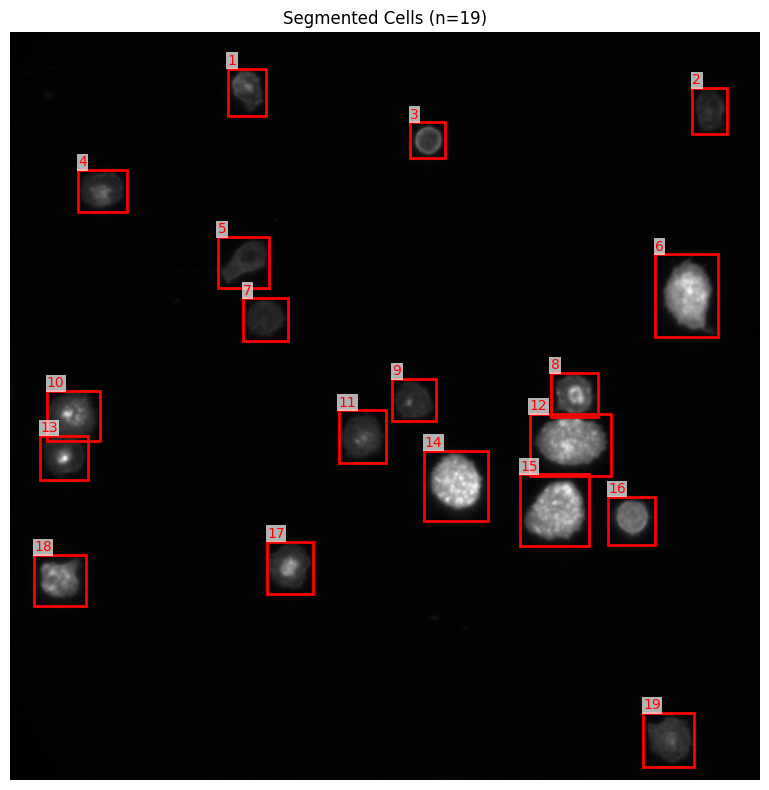

In [5]:
# Perform segmentation
if 'image' in locals() and 'mask' in locals():
    regions, bboxes, labeled_mask = segment_cells_from_mask(image, mask, MIN_SIZE, MAX_SIZE)
    
    print(f"✅ Found {len(regions)} valid cells")
    print(f"Parameters: min_distance={MIN_DISTANCE}, min_size={MIN_SIZE}, max_size={MAX_SIZE}")
    
    # Visualize segmentation
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(image, cmap='gray')
    
    for i, (x, y, w, h) in enumerate(bboxes):
        rect = Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        
        # Add cell number
        ax.text(x, y-5, f'{i+1}', fontsize=10, color='red',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))
    
    ax.set_title(f'Segmented Cells (n={len(regions)})')
    ax.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Please load images first")

In [6]:
# Export cell ROIs for ImageJ
def export_cell_rois(image, mask, labeled_mask, regions, base_dir):
    """Export individual cell ROIs as binary masks for ImageJ"""
    roi_dir = os.path.join(base_dir, 'cell_rois')
    os.makedirs(roi_dir, exist_ok=True)
    
    for i, region in enumerate(regions):
        # Create binary mask for this single cell
        single_cell_mask = (labeled_mask == region.label).astype(np.uint8) * 255
        
        # Save each cell as separate binary image
        roi_path = os.path.join(roi_dir, f'cell_{i+1:02d}.tif')
        io.imsave(roi_path, single_cell_mask)
    
    # Also save original for reference
    original_path = os.path.join(base_dir, 'original_image.tif')
    io.imsave(original_path, image.astype(np.uint8))
    
    return roi_dir

if 'regions' in locals():
    roi_dir = export_cell_rois(image, mask, labeled_mask, regions, base_dir)
    print(f"✅ Exported {len(regions)} cell ROIs to: {roi_dir}")
    print(f"✅ Exported original image to: {base_dir}/original_image.tif")
else:
    print("⚠️ Please run segmentation first")

✅ Exported 19 cell ROIs to: /Users/taeeonkong/Desktop/Project/Summer2025/20250729_CLLSaSa/1to10/sample1/2/cell_rois
✅ Exported original image to: /Users/taeeonkong/Desktop/Project/Summer2025/20250729_CLLSaSa/1to10/sample1/2/original_image.tif


/Users/taeeonkong/Desktop/AnalysisPractice/scripts/.venv/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Users/taeeonkong/Desktop/Project/Summer2025/20250729_CLLSaSa/1to10/sample1/2/cell_rois/cell_01.tif is a low contrast image
  return func(*args, **kwargs)
/Users/taeeonkong/Desktop/AnalysisPractice/scripts/.venv/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Users/taeeonkong/Desktop/Project/Summer2025/20250729_CLLSaSa/1to10/sample1/2/cell_rois/cell_02.tif is a low contrast image
  return func(*args, **kwargs)
/Users/taeeonkong/Desktop/AnalysisPractice/scripts/.venv/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Users/taeeonkong/Desktop/Project/Summer2025/20250729_CLLSaSa/1to10/sample1/2/cell_rois/cell_03.tif is a low contrast image
  return func(*args, **kwargs)
/Users/taeeonkong/Desktop/AnalysisPractice/scripts/.venv/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Users/taeeonkong/D

In [7]:
# Export raw crops for quality filtering
def export_raw_crops(image, bboxes, base_dir, base_filename):
    """Export raw (unpadded) cell crops for quality filtering"""
    raw_crops_dir = os.path.join(base_dir, 'raw_crops')
    os.makedirs(raw_crops_dir, exist_ok=True)
    
    for i, (x, y, w, h) in enumerate(bboxes):
        # Raw crop without padding
        cropped = image[y:y+h, x:x+w]
        
        if cropped.size == 0:
            print(f"⚠️ Skipping empty bbox {i+1}")
            continue
        
        # Save as numbered files for easier sorting
        save_path = os.path.join(raw_crops_dir, f'cell_{i+1:02d}.tif')
        io.imsave(save_path, cropped.astype(np.uint8))
    
    return raw_crops_dir

if 'bboxes' in locals():
    base_name = os.path.splitext(raw_filename)[0]
    raw_crops_dir = export_raw_crops(image, bboxes, base_dir, base_name)
    print(f"✅ Exported {len(bboxes)} raw crops to: {raw_crops_dir}")
    print("\n📋 Next steps:")
    print("1. Run filter_bad_images.ipynb to identify good/bad cells")
    print("2. Use ImageJ extractCells macro with cell_rois/ to get crops")
    print("3. Apply padding to good cells for final processing")
else:
    print("⚠️ Please run segmentation first")

✅ Exported 19 raw crops to: /Users/taeeonkong/Desktop/Project/Summer2025/20250729_CLLSaSa/1to10/sample1/2/raw_crops

📋 Next steps:
1. Run filter_bad_images.ipynb to identify good/bad cells
2. Use ImageJ extractCells macro with cell_rois/ to get crops
3. Apply padding to good cells for final processing
